## Schools in Dublin

#### Import necessary library

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point
import pandas.io.sql as sqlio
import geopandas as gpd
import psycopg2
import requests
from matplotlib.patches import Patch

#### Connect to postgrea server

In [4]:
try:
    dbConnection = psycopg2.connect(
        user = "postgres",
        password = "samyadhu",
        host = "127.0.0.1",
        port = "5432",
        database = "schools")
    dbConnection.set_isolation_level(0)
    dbCursor = dbConnection.cursor()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)

#### Load the processed data for visualization

In [7]:
main_frame_sql = """
SELECT
 official_name,
 county,
 local_authority,
 eircode,
 irish_classification,
 ethos_description,
 female,
 male,
 total,
 latitude,
 longitude,
 garda_division,
 'main_stream_school' as school_type
FROM
  mainstream_school_processed
where garda_division is not null
  ;"""

special_school_sql = """
SELECT
'special_school' as official_name,
county,
local_authority,
eircode,
irish_classification,
ethos_description,
0 as female,
0 as male,
enrolment_per_return as total,
latitude,
longitude,
garda_division,
school_type
FROM
  special_school_processed
where garda_division is not null;
"""

post_primary_school_sql = """
SELECT
official_school_name as official_name,
county,
local_authority,
eircode,
irish_classification,
ethos as ethos_description,
female,
male,
total,
latitude,
longitude,
garda_division,
post_primary_school_type as school_type
FROM
  post_primary_school_processed
where garda_division is not null;
"""

mainframe_dataframe = sqlio.read_sql_query(main_frame_sql, dbConnection)
special_school_dataframe = sqlio.read_sql_query(special_school_sql, dbConnection)
post_primary_dataframe = sqlio.read_sql_query(post_primary_school_sql, dbConnection)

C:\Users\samru\AppData\Local\Temp\ipykernel_16524\1207548055.py:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mainframe_dataframe = sqlio.read_sql_query(main_frame_sql, dbConnection)
C:\Users\samru\AppData\Local\Temp\ipykernel_16524\1207548055.py:62: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  special_school_dataframe = sqlio.read_sql_query(special_school_sql, dbConnection)
C:\Users\samru\AppData\Local\Temp\ipykernel_16524\1207548055.py:63: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  post_primary_dataframe = sqlio.r

In [8]:
schools_df = pd.concat([mainframe_dataframe, special_school_dataframe,post_primary_dataframe], ignore_index=True, sort=False)

In [9]:
schools_df.head()

,official_name,county,local_authority,eircode,irish_classification,ethos_description,female,male,total,latitude,longitude,garda_division,school_type
0,ST BRIGIDS MXD N S,Dublin,Fingal County Council,D15P820,No subjects through Irish,Catholic,447.0,502.0,949,53.375089,-6.362184,DMR West,main_stream_school
1,LUCAN B N S,Dublin,South Dublin County Council,K78YD27,No subjects through Irish,Catholic,NaN,513.0,513,53.359551,-6.443592,DMR West,main_stream_school
2,CLOCHAR LORETO N S,Dublin,South Dublin County Council,D14YY28,No subjects through Irish,Catholic,501.0,NaN,501,53.291279,-6.278829,DMR South,main_stream_school
3,CENTRAL SENIOR MXD N S,Dublin,Dublin City Council,D01P027,No subjects through Irish,Catholic,133.0,143.0,276,53.351488,-6.256009,DMR North Central,main_stream_school
4,S N NA H-AILLE,Dublin,Fingal County Council,K32PX40,No subjects through Irish,Catholic,67.0,72.0,139,53.578874,-6.285636,DMR North,main_stream_school


#### Distribution of schools in garda division

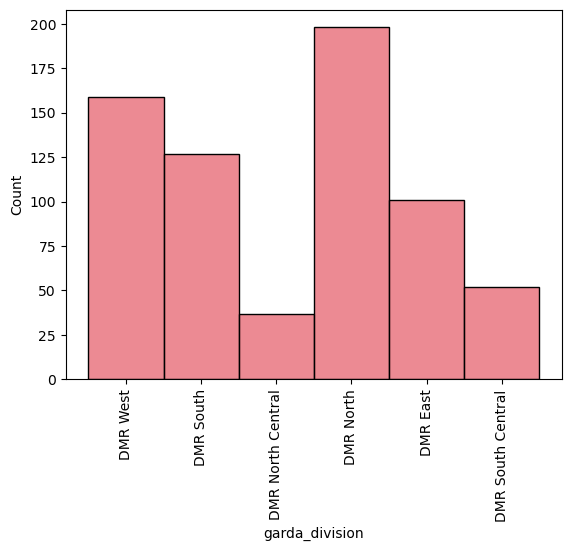

In [10]:
sns.histplot(schools_df['garda_division'],color='#e6636f')
plt.xticks(rotation=90)
plt.show()

#### Distribution of schools in council

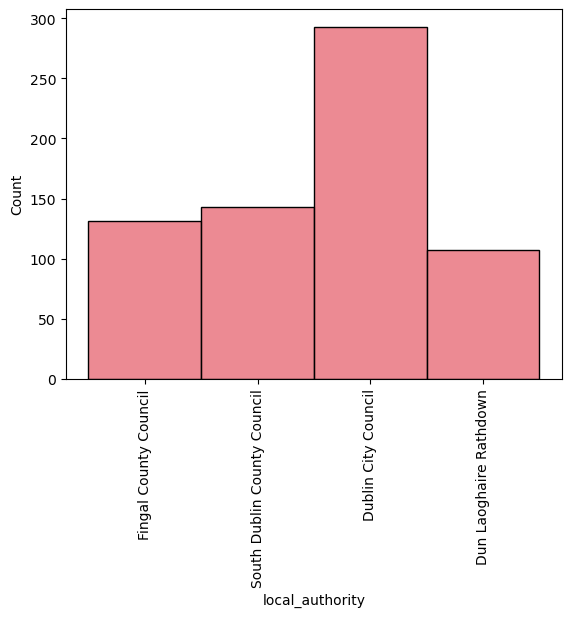

In [12]:
sns.histplot(schools_df['local_authority'],color='#e6636f')
plt.xticks(rotation=90)#### Distribution of schools in garda division
plt.show()

#### Distribution of types of schools in council

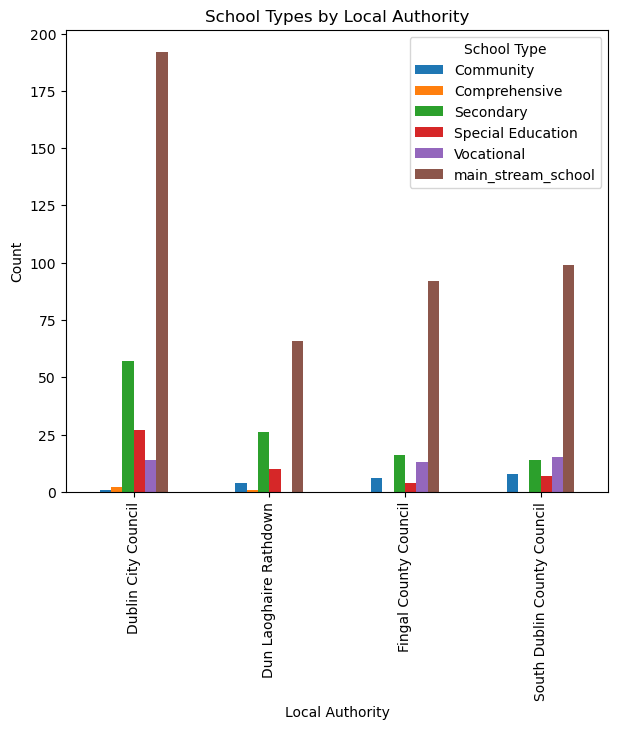

In [13]:
grouped = schools_df.groupby(['local_authority', 'school_type']).size().unstack()

grouped.plot(kind='bar', figsize=(7, 6))
plt.title('School Types by Local Authority')
plt.xlabel('Local Authority')
plt.ylabel('Count')
plt.legend(title='School Type', bbox_to_anchor=(1, 1))
plt.show()

#### Male and female students across all types of schools

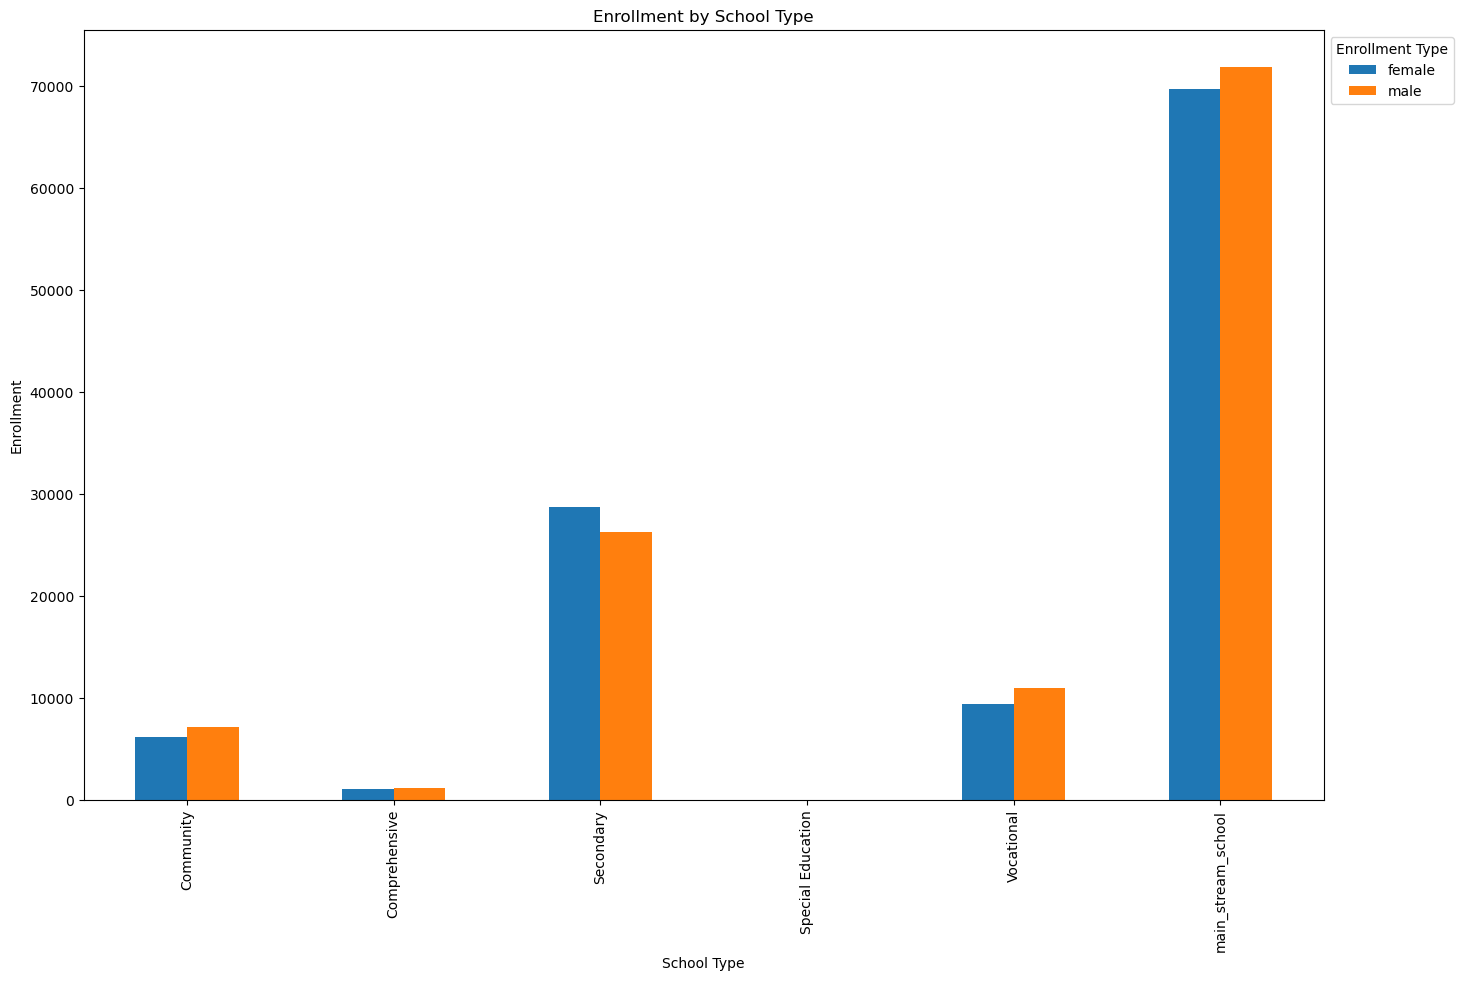

In [14]:
grouped_data = schools_df.groupby('school_type')[['female', 'male']].sum()

grouped_data.plot(kind='bar', figsize=(16, 10))
plt.title('Enrollment by School Type')
plt.xlabel('School Type')
plt.ylabel('Enrollment')
plt.legend(title='Enrollment Type', bbox_to_anchor=(1, 1))
plt.show()

#### Distribution of types of schools in garda division

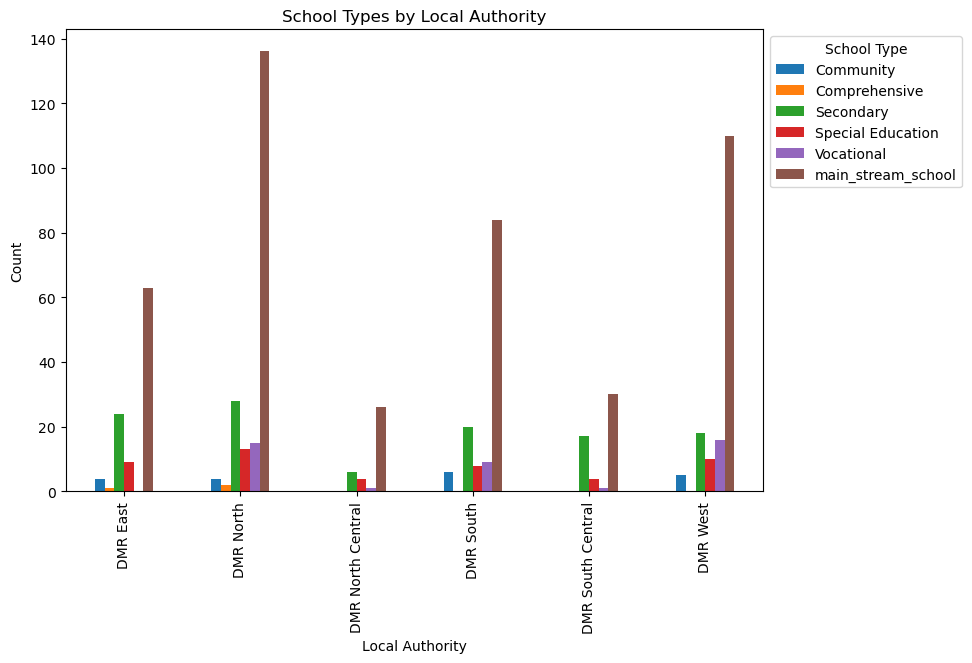

In [24]:
grouped_grada = schools_df.groupby(['garda_division', 'school_type']).size().unstack()

grouped_grada.plot(kind='bar', figsize=(9, 6))
plt.title('School Types by Local Authority')
plt.xlabel('Local Authority')
plt.ylabel('Count')
plt.legend(title='School Type', bbox_to_anchor=(1, 1))
plt.show()

#### Pie chart of different types of schools

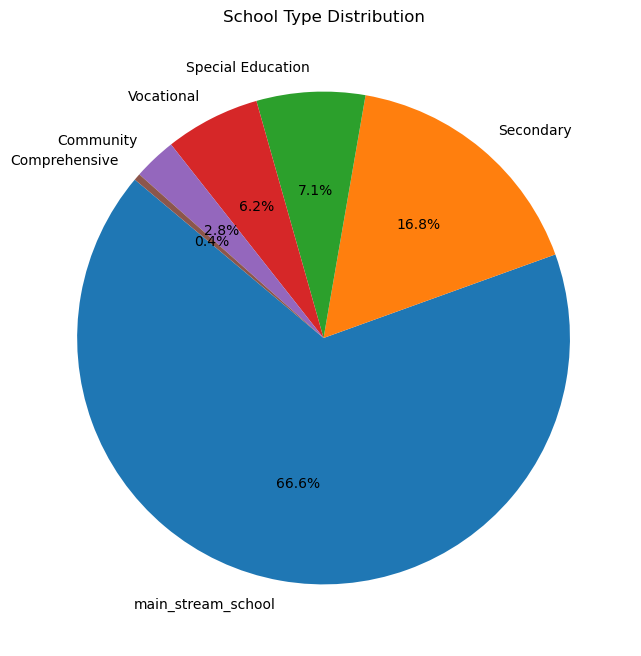

In [25]:
school_type_counts = schools_df['school_type'].value_counts()

fig, axs = plt.subplots(1, 1, figsize=(10, 8))

axs.pie(school_type_counts, labels=school_type_counts.index, autopct='%1.1f%%', startangle=140)
axs.set_title('School Type Distribution')
plt.show()

In [19]:
school_north = schools_df[schools_df['garda_division'] == 'DMR North'].copy()
school_north_central = schools_df[schools_df['garda_division'] == 'DMR North Central'].copy()
school_south = schools_df[schools_df['garda_division'] == 'DMR South'].copy()
school_south_central = schools_df[schools_df['garda_division'] == 'DMR South Central'].copy()
school_west = schools_df[schools_df['garda_division'] == 'DMR West'].copy()
school_east = schools_df[schools_df['garda_division'] == 'DMR East'].copy()

In [20]:
# Create a dictionary to map each division to a unique color
division_colors = {
    'DMR North': 'moccasin',
    'DMR South': 'lightblue',
    'DMR East': 'lightgreen',
    'DMR West': 'gray',
    'DMR North Central': 'lavender',
    'DMR South Central': 'lightpink'
}

gdf = gpd.read_file("Garda_Districts_-_An_Garda_Siochana.geojson")
dublin_gdf = gdf[gdf['Division'].str.contains('DMR', case=False)]

#### Geographical representation of schools distribution

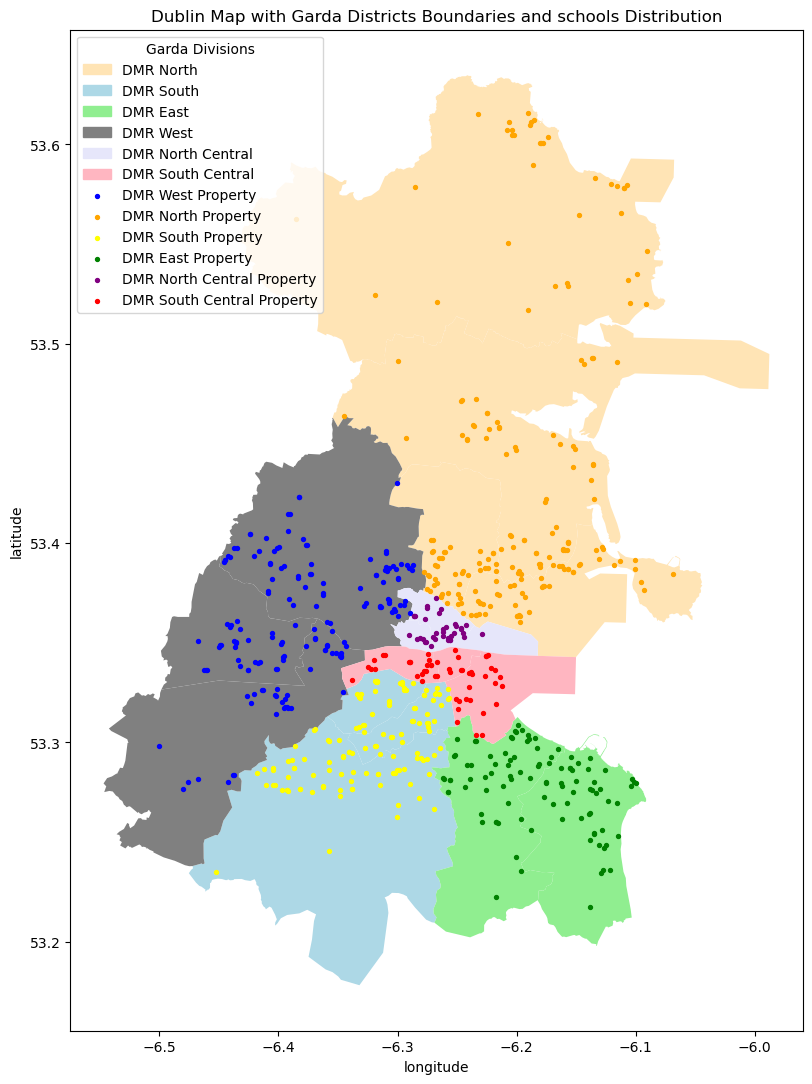

In [22]:
fig, ax = plt.subplots(figsize=(13, 13))
for division, color in division_colors.items():
     dublin_gdf[dublin_gdf['Division'] == division].plot(ax=ax, color=color, label=division)

legend_handles = [Patch(color=color, label=division) for division, color in division_colors.items()]
ax.legend(handles=legend_handles, title='Garda Divisions')

plt.title("Dublin Map with Garda Districts Boundaries and schools Distribution")

school_west.plot(kind='scatter', x='longitude', y='latitude', color='blue', ax=ax, label='DMR West Property',s=8)
school_north.plot(kind='scatter', x='longitude', y='latitude', color='orange', ax=ax, label='DMR North Property',s=8)
school_south.plot(kind='scatter', x='longitude', y='latitude', color='yellow', ax=ax, label='DMR South Property',s=8)
school_east.plot(kind='scatter', x='longitude', y='latitude', color='green', ax=ax, label='DMR East Property',s=8)
school_north_central.plot(kind='scatter', x='longitude', y='latitude', color='purple', ax=ax, label='DMR North Central Property',s=8)
school_south_central.plot(kind='scatter', x='longitude', y='latitude', color='red', ax=ax, label='DMR South Central Property',s=8)

plt.show()